In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import concat
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error as MSE

Source : https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

# Time Series vs Supervised Learning


## Pandas shift() Function


A key function to help transform time series data into a supervised learning problem is the Pandas shift() function.

Given a DataFrame, the shift() function can be used to create copies of columns that are pushed forward (rows of NaN values added to the front) or pulled back (rows of NaN values added to the end).

This is the behavior required to create columns of lag observations as well as columns of forecast observations for a time series dataset in a supervised learning format.

Let’s look at some examples of the shift function in action.

We can define a mock time series dataset as a sequence of 10 numbers, in this case a single column in a DataFrame as follows:

In [2]:
df = DataFrame()
df['t'] = [x for x in range(10)]
print(df)

   t
0  0
1  1
2  2
3  3
4  4
5  5
6  6
7  7
8  8
9  9


We can shift all the observations down by one time step by inserting one new row at the top. Because the new row has no data, we can use NaN to represent “no data”.

The shift function can do this for us and we can insert this shifted column next to our original series.

In [3]:
df['t-1'] = df['t'].shift(1)
print(df)

   t  t-1
0  0  NaN
1  1  0.0
2  2  1.0
3  3  2.0
4  4  3.0
5  5  4.0
6  6  5.0
7  7  6.0
8  8  7.0
9  9  8.0


We can see that shifting the series forward one time step gives us a primitive supervised learning problem, although with X and y in the wrong order. Ignore the column of row labels. The first row would have to be discarded because of the NaN value. The second row shows the input value of 0.0 in the second column (input or X) and the value of 1 in the first column (output or y).

We can see that if we can repeat this process with shifts of 2, 3, and more, how we could create long input sequences (X) that can be used to forecast an output value (y).

The shift operator can also accept a negative integer value. This has the effect of pulling the observations up by inserting new rows at the end. Below is an example:

In [4]:
df = DataFrame()
df['t'] = [x for x in range(10)]
df['t+1'] = df['t'].shift(-1)
print(df)

   t  t+1
0  0  1.0
1  1  2.0
2  2  3.0
3  3  4.0
4  4  5.0
5  5  6.0
6  6  7.0
7  7  8.0
8  8  9.0
9  9  NaN


Running the example shows a new column with a NaN value as the last value.

We can see that the forecast column can be taken as an input (X) and the second as an output value (y). That is the input value of 0 can be used to forecast the output value of 1.

Technically, in time series forecasting terminology the current time (t) and future times (t+1, t+n) are forecast times and past observations (t-1, t-n) are used to make forecasts.

We can see how positive and negative shifts can be used to create a new DataFrame from a time series with sequences of input and output patterns for a supervised learning problem.

This permits not only classical X -> y prediction, but also X -> Y where both input and output can be sequences.

Further, the shift function also works on so-called multivariate time series problems. That is where instead of having one set of observations for a time series, we have multiple (e.g. temperature and pressure). All variates in the time series can be shifted forward or backward to create multivariate input and output sequences. We will explore this more later in the tutorial.

# The series_to_supervised() Function


In this section, we will define a new Python function named series_to_supervised() that takes a univariate or multivariate time series and frames it as a supervised learning dataset.

The function takes four arguments:

<ul>
    <li>data: Sequence of observations as a list or 2D NumPy array. Required.</li>
    <li>n_in: Number of lag observations as input (X). Values may be between [1..len(data)] Optional. Defaults to 1.</li>
    <li>n_out: Number of observations as output (y). Values may be between [0..len(data)-1]. Optional. Defaults to 1.</li>
    <li>dropnan: Boolean whether or not to drop rows with NaN values. Optional. Defaults to True.</li>
</ul>
The function returns a single value:

<li>return: Pandas DataFrame of series framed for supervised learning.</li>

The new dataset is constructed as a DataFrame, with each column suitably named both by variable number and time step. This allows you to design a variety of different time step sequence type forecasting problems from a given univariate or multivariate time series.

Once the DataFrame is returned, you can decide how to split the rows of the returned DataFrame into X and y components for supervised learning any way you wish.

The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 as X and t as y.

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [6]:
values = [x for x in range(10)]
data = series_to_supervised(values)
print(data)

   var1(t-1)  var1(t)
1        0.0        1
2        1.0        2
3        2.0        3
4        3.0        4
5        4.0        5
6        5.0        6
7        6.0        7
8        7.0        8
9        8.0        9


We can see that the observations are named “var1” and that the input observation is suitably named (t-1) and the output time step is named (t).

We can also see that rows with NaN values have been automatically removed from the DataFrame.

We can repeat this example with an arbitrary number length input sequence, such as 3. This can be done by specifying the length of the input sequence as an argument; for example:

In [7]:
data = series_to_supervised(values, 3)
data

,var1(t-3),var1(t-2),var1(t-1),var1(t)
3,0.0,1.0,2.0,3
4,1.0,2.0,3.0,4
5,2.0,3.0,4.0,5
6,3.0,4.0,5.0,6
7,4.0,5.0,6.0,7
8,5.0,6.0,7.0,8
9,6.0,7.0,8.0,9


# Multi-Step or Sequence Forecasting


A different type of forecasting problem is using past observations to forecast a sequence of future observations.

This may be called sequence forecasting or multi-step forecasting.

We can frame a time series for sequence forecasting by specifying another argument. For example, we could frame a forecast problem with an input sequence of 2 past observations to forecast 2 future observations as follows:

In [8]:
data = series_to_supervised(values, 2, 2)
print(data)

   var1(t-2)  var1(t-1)  var1(t)  var1(t+1)
2        0.0        1.0        2        3.0
3        1.0        2.0        3        4.0
4        2.0        3.0        4        5.0
5        3.0        4.0        5        6.0
6        4.0        5.0        6        7.0
7        5.0        6.0        7        8.0
8        6.0        7.0        8        9.0


# Multivariate Forecasting


See source if you need in the future

# HeartRate Study case

In [173]:
heartrate_df = pd.read_csv ('.\Data\HEARTRATE_AUTO_1658994387948.csv', sep=',', header=0)

In [174]:
heartrate_df['date'] = pd.to_datetime(heartrate_df['date'],infer_datetime_format=True) #convert from string to datetime
heartrate_df['time'] = pd.to_datetime(heartrate_df['time'], format='%H:%M').dt.strftime("%H:%M")

heartrate_df['date'] = pd.to_datetime(heartrate_df['date'].astype(str)+' '+heartrate_df['time'].astype(str), format='%Y-%m-%d %H:%M')
heartrate_df['date'] = heartrate_df['date'].dt.strftime('%Y-%m-%d %H:%M')
heartrate_df = heartrate_df.drop(columns=['time'])

# generating the indexed dataset
indexed_dataset = heartrate_df.set_index(['date'])
indexed_dataset_copy = indexed_dataset.copy()

In [175]:
starting_date = datetime.strptime(heartrate_df['date'].iloc[0], '%Y-%m-%d %H:%M').strftime("%Y-%m-%d")
end_date = datetime.strptime(heartrate_df['date'].iloc[-1], '%Y-%m-%d %H:%M').strftime("%Y-%m-%d")
print('Start date: {}\nEnd date: {}'.format(starting_date, end_date))

Start date: 2022-06-12
End date: 2022-06-19


In [176]:
HR_values = indexed_dataset['heartRate'].tolist()
size = len(HR_values) - 331
train= HR_values[0:size]

In [177]:
data = series_to_supervised(HR_values, len(train) , 331)
prediction = data.iloc[0,len(train):].tolist()

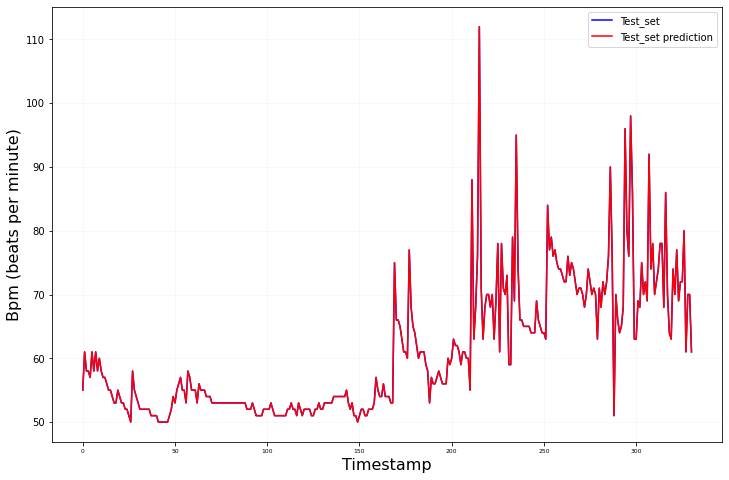

In [178]:
plt.figure(figsize = (12,8)) # declaire environment to draw
plt.plot(HR_values[size:], c='blue', label='Test_set')
plt.plot(prediction, c='red', label='Test_set prediction')
plt.xlabel("Timestamp", fontsize=16)
plt.ylabel("Bpm (beats per minute)", fontsize=16)
plt.tick_params(axis='x', labelsize=6)
plt.tick_params(axis='y', labelsize=10)
plt.grid(alpha=0.1)
plt.legend()
plt.show()

<h6>Personal Opinion: This is fraud </h6>

# Random Forest Model

Source : https://www.youtube.com/watch?v=BJ6kyj-st9k

In [179]:
indexed_dataset

,heartRate
date,
2022-06-12 09:25,68
2022-06-12 09:28,68
2022-06-12 09:35,80
2022-06-12 09:45,70
2022-06-12 09:55,64
...,...
2022-06-19 23:16,80
2022-06-19 23:26,61
2022-06-19 23:36,70


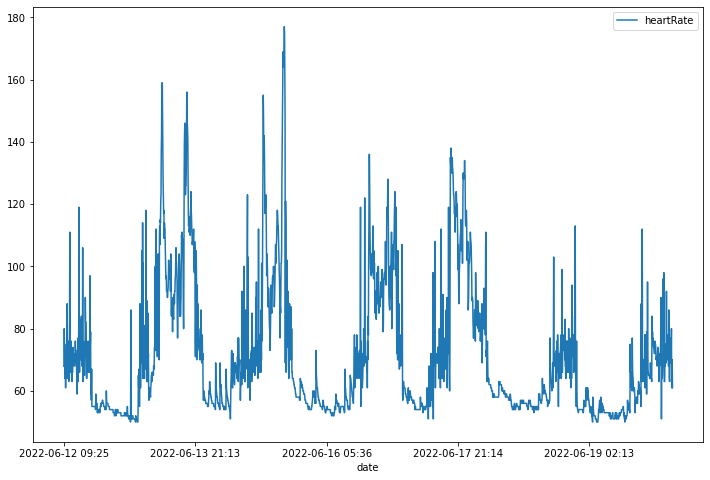

In [180]:
indexed_dataset.plot(figsize=(12,8))
plt.show()

In [181]:
def add_shifting(dataset, ylabel, column_to_add=1):
    for i in range(1,column_to_add+1):
        dataset['-'+str(i)] = dataset[ylabel].shift(+i)
    #Dropping null values
    dataset = dataset.dropna()
    return dataset

In [182]:
n_back_mem_features = 14 #manually tested and selected=14
ylabel ='heartRate'
indexed_dataset = add_shifting(indexed_dataset, ylabel, n_back_mem_features)

In [183]:
indexed_dataset

,heartRate,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14
date,,,,,,,,,,,,,,,
2022-06-12 11:35,64,88.0,83.0,68.0,75.0,68.0,72.0,61.0,72.0,68.0,64.0,70.0,80.0,68.0,68.0
2022-06-12 11:45,67,64.0,88.0,83.0,68.0,75.0,68.0,72.0,61.0,72.0,68.0,64.0,70.0,80.0,68.0
2022-06-12 11:55,75,67.0,64.0,88.0,83.0,68.0,75.0,68.0,72.0,61.0,72.0,68.0,64.0,70.0,80.0
2022-06-12 12:05,76,75.0,67.0,64.0,88.0,83.0,68.0,75.0,68.0,72.0,61.0,72.0,68.0,64.0,70.0
2022-06-12 12:15,69,76.0,75.0,67.0,64.0,88.0,83.0,68.0,75.0,68.0,72.0,61.0,72.0,68.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-19 23:16,80,72.0,72.0,69.0,77.0,70.0,74.0,63.0,64.0,70.0,86.0,68.0,78.0,78.0,74.0
2022-06-19 23:26,61,80.0,72.0,72.0,69.0,77.0,70.0,74.0,63.0,64.0,70.0,86.0,68.0,78.0,78.0
2022-06-19 23:36,70,61.0,80.0,72.0,72.0,69.0,77.0,70.0,74.0,63.0,64.0,70.0,86.0,68.0,78.0


In [184]:
# X = input matrix, y = output array
X = indexed_dataset.iloc[:, 1:n_back_mem_features+1].values # column to select
y = indexed_dataset[ylabel]
X_train, X_test, y_train, y_test = X[:-331], X[-331:], y[:-331], y[-331:]

In [186]:
optimum_MSE = np.inf
optimum_n_estimators = 0
for i in range(1,100):
    random_forest_model = RandomForestRegressor(n_estimators=i, max_features=1, random_state=1) #random_forest_model
    random_forest_model.fit(X_train, y_train)
    pred = random_forest_model.predict(X_test)
    rmse_rand_forest = np.round(sqrt(MSE(pred,y_test)),2)
    if(rmse_rand_forest < optimum_MSE):
        optimum_MSE = rmse_rand_forest
        optimum_n_estimators = i
    print("{}) Random Forest Model: MSE = {}".format(i,rmse_rand_forest))
print("# of estimators to be used = {} (MSE = {})".format(optimum_n_estimators,optimum_MSE))   

1) Random Forest Model: MSE = 8.49
2) Random Forest Model: MSE = 7.43
3) Random Forest Model: MSE = 6.91
4) Random Forest Model: MSE = 6.75
5) Random Forest Model: MSE = 6.55
6) Random Forest Model: MSE = 6.44
7) Random Forest Model: MSE = 6.45
8) Random Forest Model: MSE = 6.37
9) Random Forest Model: MSE = 6.38
10) Random Forest Model: MSE = 6.38
11) Random Forest Model: MSE = 6.37
12) Random Forest Model: MSE = 6.32
13) Random Forest Model: MSE = 6.28
14) Random Forest Model: MSE = 6.28
15) Random Forest Model: MSE = 6.19
16) Random Forest Model: MSE = 6.21
17) Random Forest Model: MSE = 6.17
18) Random Forest Model: MSE = 6.18
19) Random Forest Model: MSE = 6.12
20) Random Forest Model: MSE = 6.16
21) Random Forest Model: MSE = 6.14
22) Random Forest Model: MSE = 6.06
23) Random Forest Model: MSE = 6.08
24) Random Forest Model: MSE = 6.03
25) Random Forest Model: MSE = 6.04
26) Random Forest Model: MSE = 6.0
27) Random Forest Model: MSE = 5.98
28) Random Forest Model: MSE = 5.97
29

Using Optimum value

In [187]:
random_forest_model = RandomForestRegressor(n_estimators=optimum_n_estimators, max_features=1, random_state=1) #random_forest_model
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(max_features=1, n_estimators=39, random_state=1)

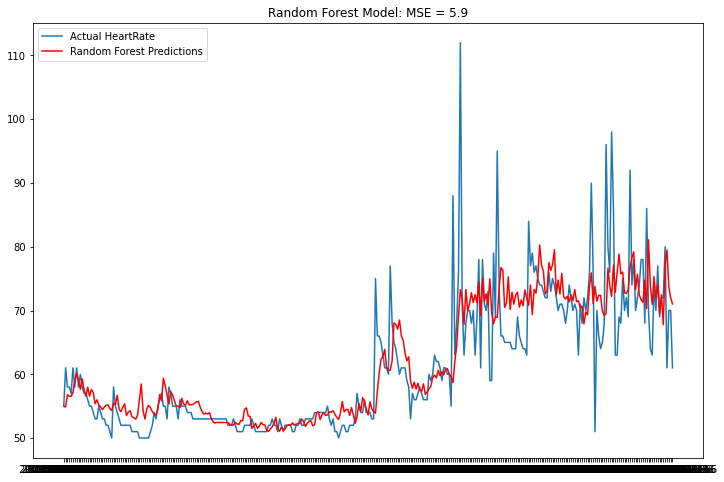

In [188]:
pred = random_forest_model.predict(X_test)
rmse_rand_forest = np.round(sqrt(MSE(pred,y_test)),2)

plt.rcParams['figure.figsize'] = (12,8)
plt.plot(y_test, label="Actual HeartRate")
plt.plot(pred, label="Random Forest Predictions", color='r')
plt.legend(loc='upper left')
plt.title("Random Forest Model: MSE = {}".format(rmse_rand_forest))
plt.show()

Better MSE, but not follow the peaks

## Alternative hyperparameters

In [189]:
n_back_mem_features = 4 
indexed_dataset_copy = add_shifting(indexed_dataset_copy, ylabel, n_back_mem_features)

In [190]:
# X = input matrix, y = output array
X = indexed_dataset_copy.iloc[:, 1:n_back_mem_features+1].values # column to select
y = indexed_dataset_copy[ylabel]
X_train, X_test, y_train, y_test = X[:-331], X[-331:], y[:-331], y[-331:]

In [191]:
random_forest_model = RandomForestRegressor(n_estimators=optimum_n_estimators, max_features=n_back_mem_features, random_state=1) #random_forest_model
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(max_features=4, n_estimators=39, random_state=1)

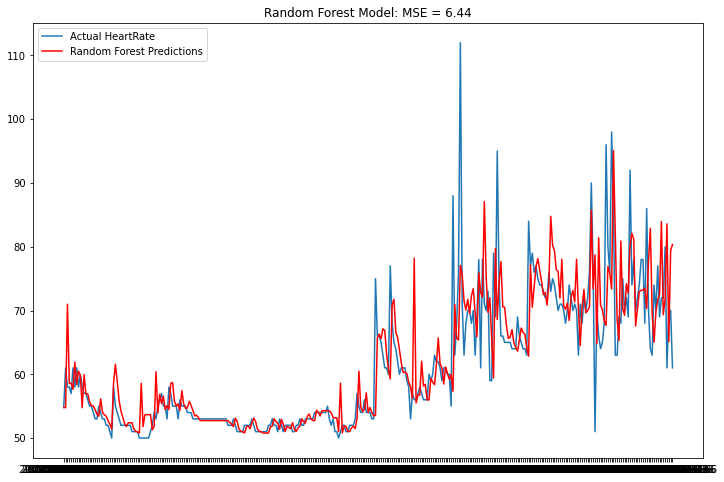

In [192]:
pred = random_forest_model.predict(X_test)
rmse_rand_forest = np.round(sqrt(MSE(pred,y_test)),2)

plt.rcParams['figure.figsize'] = (12,8)
plt.plot(y_test, label="Actual HeartRate")
plt.plot(pred, label="Random Forest Predictions", color='r')
plt.legend(loc='upper left')
plt.title("Random Forest Model: MSE = {}".format(rmse_rand_forest))
plt.show()

MMHH not so good with peaks as expected

# Linear Regression Model

In [30]:
lin_model = LinearRegression() # linear model

In [31]:
lin_model.fit(X_train, y_train)

LinearRegression()

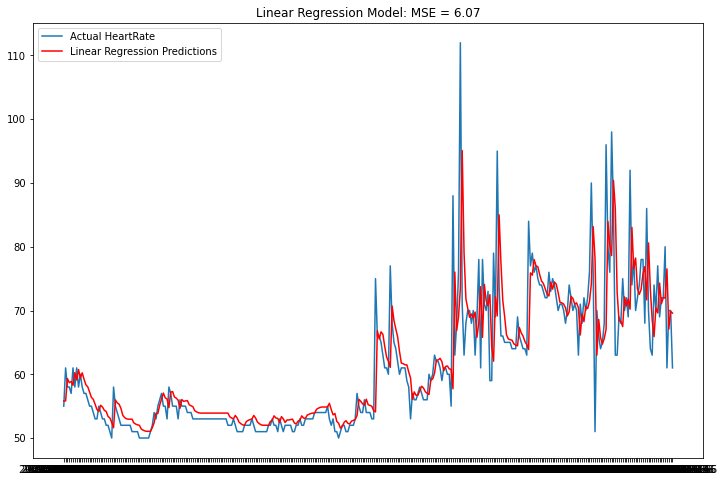

In [32]:
lin_pred = lin_model.predict(X_test)
rmse_lin_reg = np.round(sqrt(MSE(lin_pred,y_test)),2)

plt.rcParams['figure.figsize'] = (12,8)
plt.plot(y_test, label="Actual HeartRate")
plt.plot(lin_pred, label="Linear Regression Predictions", color='r')
plt.legend(loc='upper left')
plt.title("Linear Regression Model: MSE = {}".format(rmse_lin_reg))
plt.show()